STEP BY STEP OF NEST SIMULATION
1) IMPORTING RELEVANT DATA FROM SNUDDA GENERATED NEURON FILES:\
    a. Neuron Matrix: to keep the info of neuron types \
    b. Synaptic Matrix: Where each row has the info of [preID, posID] of one synapse \
    for now every synapse will have the same properties, no matter the types of neurons\
    (later we can add more info on this matrix that will help set the type of synapses used for each)\
    c*. (optional/not really relevant but already available) Positions: matrix with coordinates for each neuron position\
    d.Info about the input given to the neurons
2) CREATING THE NEST NETWORK \
    a. Create the neurons (the correct # of neurons, in their posiiton*)\
    b. Connect the neurons (for loop with Synaptic Matrix as info)\
    c. Connect the measuring devices to the neurons in order to observe spiking and voltage \
    d. Feed the input\
3) RUN THE SIM
    

In [1]:
import nest
from getData import *
from plot import *

In [2]:
positions_list = getNeuronPositions('/home/ubuntu/BasalGanglia/NEURON-data/net_100/network-neuron-positions.hdf5')

In [3]:
pos = nest.spatial.free(positions_list) # using NEURON positions

s_nodes = nest.Create("iaf_cond_alpha", 99, positions=pos) #create all the neurons at once, with same characteristics
#needs to be upgraded to a function, that will change neuron specifications according to type 
#(once this is done changes in the connection protocol will be needed (bc they wont all be in one pop))


In [4]:
############################## THIS FUNCTION WILL BE HELD ON THE .PY FILE   #################################
#def getSynapses(path):
    
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/network-pruned-synapses.hdf5', 'r') as file:
    synapses = file.get('network').get('synapses')

    synaptic_matrix = []
    for i in range(0,len(synapses)):
        synaptic_matrix.append([synapses[i][0], synapses[i][1]]) #Pre_ID | Pos_ID

#    return(synaptic_matrix)  
#####################################

for i in range(0,len(synaptic_matrix)):
    nest.Connect(s_nodes[synaptic_matrix[i][0]],s_nodes[synaptic_matrix[i][1]])
    


In [17]:
# THIS WAS A SECOND IDEA ON HOW TO CONNECT THE NETWORK BUT -> to loop the array creation but not the nest connect command 
# so it doesnt get too heavy. so far it is not working.

pre_list = []
pos_list = []

for i in range(0,len(synaptic_matrix)):
    pre_list.append(s_nodes['global_id' == synaptic_matrix[i][0]])
    pos_list.append(s_nodes['global_id' == synaptic_matrix[i][1]])

    

nest.Connect(pre_list,pos_list,conn_spec= "one_to_one")


ValueError: Sources and targets must be 1-dimensional arrays

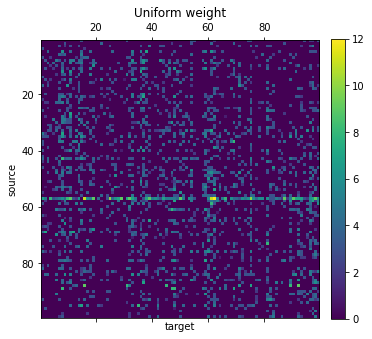

In [14]:
##### HOW TO ENSURE THAT THE INFORMATION WAS PROPERLY INSERTED? THAT IS, THAT THE CONNECTIONS ARE EQUAL TO THE NEST ONES######
# NO NEED TO PROVE THIS. BUT THIS CONN MATRIX, IF I MANAGE TO ORDER NEURONS BY THEIR TYPE, CAN PROVIDE INSIGHTS NONETHELESS
conns = nest.GetConnections(s_nodes, s_nodes)  # This returns a SynapseCollection
# We can get desired information of the SynapseCollection with simple get() call.
g = conns.get(['source', 'target', 'weight'])
srcs = g['source']
tgts = g['target']
weights = g['weight']

# Plot the matrix consisting of the weights between the sources and targets
plt.figure(figsize=(12, 10))
plotMatrix(srcs, tgts, weights, 'Uniform weight', 121)

In [8]:
help(nest.Connect)

Help on function Connect in module nest.lib.hl_api_connections:

Connect(pre, post, conn_spec=None, syn_spec=None, return_synapsecollection=False)
    Connect `pre` nodes to `post` nodes.
    
    Nodes in `pre` and `post` are connected using the specified connectivity
    (`all-to-all` by default) and synapse type (:cpp:class:`static_synapse <nest::static_synapse>` by default).
    Details depend on the connectivity rule.
    
    Parameters
    ----------
    pre : NodeCollection (or array-like object)
        Presynaptic nodes, as object representing the IDs of the nodes
    post : NodeCollection (or array-like object)
        Postsynaptic nodes, as object representing the IDs of the nodes
    conn_spec : str or dict, optional
        Specifies connectivity rule, see below
    syn_spec : str or dict, optional
        Specifies synapse model, see below
    return_synapsecollection: bool
        Specifies whether or not we should return a :py:class:`.SynapseCollection` of pre and post